In [82]:

from gwpy.timeseries import TimeSeries
from scipy.signal import spectrogram
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from burst_search_pipeline.lvk_interferometers import load_interferometers_with_injection
from burst_search_pipeline.plotting import plot_time_domain
import numpy as np

fs = SAMPLING_FREQ = 4096
np.random.seed(1)
injection_parameters = dict(
    luminosity_distance=2,  # kpc
    geocent_time=1126259642.413,
    ra=0,
    dec=0,
    psi=0
)

data = load_interferometers_with_injection(injection_parameters)

supernova_y = data.time_domain_strain['plus']
t0 = data.interferometers[0].strain_data.start_time
supernova_time = data.interferometers[0].strain_data.time_array - t0
supernova_data = data.interferometers[0].strain_data.time_domain_strain
# supernova_y = np.roll(supernova_y, 55)
supernova_data = np.roll(supernova_data, 55)


2024-11-11 15:58:01.875 | INFO     | starccato.utils:generate_signals:81 - Generated 1 signals [0.01s].
2024-11-11 15:58:01.999 | INFO     | starccato.utils:generate_signals:81 - Generated 1 signals [0.01s].


array([<Axes: ylabel='Strain'>,
       <Axes: xlabel='GPS time [s] - -0.4', ylabel='Frequency [Hz]'>],
      dtype=object)

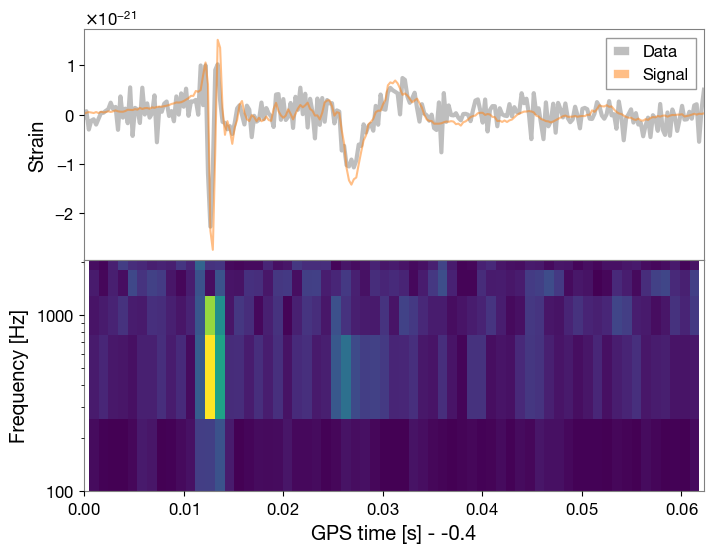

In [120]:
def plot_comparison(time_x, sig_y, data_y, interp_factor=8):
    interp = interp1d(x=time_x, y=data_y,kind='cubic')
    xinterp = np.linspace(time_x[0],time_x[-1], len(time_x)*interp_factor)
    yinterp = interp(xinterp)
    new_fs = 1/(xinterp[1]-xinterp[0])
    
    specf, spect, Sxx = spectrogram(
        yinterp,
        fs=new_fs,
        scaling='spectrum',
        mode='magnitude',
        nperseg=64,
        noverlap=32,
        
    )
    
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    xlabel = f'GPS time [s] - {t0}'
    
    axes[0].plot(time_x, data_y, color="tab:gray", label=f"Data", alpha=0.5, lw=3)
    axes[0].plot(time_x, sig_y, color="tab:orange", label=f'Signal', alpha=0.5)
    axes[0].set_ylabel('Strain')
    axes[0].legend()
    
    axes[1].pcolormesh(spect, specf, Sxx)
    axes[1].set_yscale('log')
    axes[1].set_ylim([100, 2048])
    axes[1].set_ylabel('Frequency [Hz]')
    axes[1].set_xlabel(xlabel)
    axes[0].set_xlim(time_x[0], time_x[-1])
    plt.subplots_adjust(hspace=0.)
    return axes
    

plot_comparison(
    supernova_time,
    supernova_y,
    supernova_data,
    interp_factor=8
)

array([<Axes: ylabel='Strain'>,
       <Axes: xlabel='GPS time [s] - -0.4', ylabel='Frequency [Hz]'>],
      dtype=object)

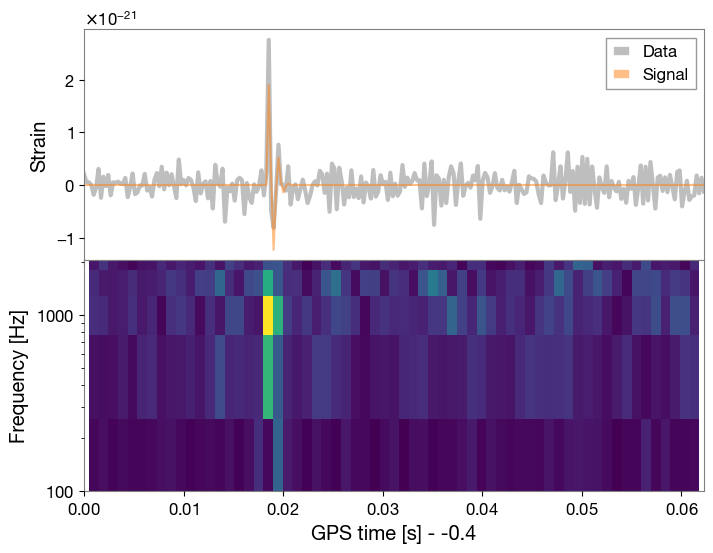

In [163]:
from burst_search_pipeline.lvk_interferometers import load_interferometers
import warnings

import bilby
import matplotlib.pyplot as plt
import numpy as np
from bilby.gw import utils as gwutils
from scipy.signal import gausspulse

np.random.seed(2)

DATA_COL = 'tab:gray'
SIGNAL_COL = 'tab:orange'
PSD_COL = 'black'

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

SAMPLING_FREQ = 4096
N_TIMESTAMPS = 256
DURATION = N_TIMESTAMPS / SAMPLING_FREQ


def __glitch(time_array, luminosity_distance, **kwargs):
    """
    A source model that reads a simulation from a text file.

    This was originally intended for use with supernova simulations, but can
    be applied to any source class.

    Parameters
    ----------
    frequency_array: array-like
        Unused (but required by the source model interface)
    file_path: str
        Path to the file containing the NR simulation. The format of this file
        should be readable by :code:`numpy.loadtxt` and have four columns
        containing the real and imaginary components of the plus and cross
        polarizations.
    luminosity_distance: float
        The distance to the source in kpc, this scales the amplitude of the
        signal. The simulation is assumed to be at 10kpc.
    kwargs:
        extra keyword arguments, this should include the :code:`file_path`

    Returns
    -------
    dict:
        A dictionary containing the plus and cross components of the signal.
    """
    fc = kwargs.get('central_freq', 1000)
    i,q, e= gausspulse(time_array, fc=fc, bw=0.5, bwr=-6, tpr=-100, retquad=True, retenv=True,)
    # waveforms generated at 10kpc, so scale to the luminosity distance
    scaling = 1e-21 * (1 / luminosity_distance)
    waveform = scaling * q
    return {'plus': waveform, 'cross': waveform}



def _get_waveform_generator():
    # Create the waveform_generator using a supernova source function
    waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
        duration=DURATION,
        sampling_frequency=SAMPLING_FREQ,
        time_domain_source_model=__glitch,
        parameter_conversion=lambda parameters: (parameters, list()),
        waveform_arguments=dict(central_freq=1000),
    )
    return waveform_generator


GLITCH_GENERATOR = _get_waveform_generator()


LM = 400
parms =dict(central_freq=2000,luminosity_distance=LM, geocent_time=-0.03, ra=0, dec=0, psi=0)
glitch_y = GLITCH_GENERATOR.time_domain_strain(parms)
glitch_y_freq = dict(
    plus=np.fft.rfft(glitch_y['plus']),
    cross=np.fft.rfft(glitch_y['plus']),
)
interferometers = load_interferometers()
interferometers.inject_signal(
    raise_error=False,
    waveform_generator=GLITCH_GENERATOR,   
    parameters=parms, 
    injection_polarizations=glitch_y_freq,
)
data = interferometers[0].strain_data

plot_comparison(
    data.time_array,
    np.roll(glitch_y['plus']*LM*2, 75),
    data.time_domain_strain,
    interp_factor=8
)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gausspulse

fs = 4096
time_array = np.linspace(0, 1, fs)
fc = 150
waveform = gausspulse(time_array, fc=fc, bw=0.5, bwr=-6, tpr=-60, retquad=False, retenv=False)
